This is a slightly involved classification notebook - using superpixels to generate features. The results look good in that we reduce commission errors. The segmentation might be 

In [1]:
%load_ext autoreload
%autoreload 2

In [87]:
from tqdm import tqdm
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from rscube.nd_tools import (get_array_from_features, 
                             get_features_from_array, 
                             get_superpixel_area_as_features, 
                             get_superpixel_means_as_features,
                             get_superpixel_stds_as_features, 
                             scale_img)
from rscube.rio_tools import (get_geopandas_features_from_array, 
                              rasterize_shapes_to_array, 
                              get_indices_from_extent, get_cropped_profile)

from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb
from pprint import pprint
import geopandas as gpd
from rasterio import plot
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import geopandas as gpd
from shapely.geometry import box
from rasterio.windows import Window
from pathlib import Path
from rasterio.crs import CRS
from dem_stitcher.rio_tools import reproject_arr_to_match_profile

Currently, we don't have a way to link chips and planet IDs we are using so this is manual.

In [3]:
PLANET_ID = '20211003_161639_91_241d_3B_AnalyticMS_SR_8b'

In [4]:
planet_image_path = Path(f'local_chips/{PLANET_ID}.tif')
planet_image_path.exists()

True

# Load Chips

Want to crop image based on chip

In [5]:
df = gpd.read_file('chips.geojson')
df.head()

,CENTERX,CENTERY,STRATA,SAMPLE_ID,date,LS_Validat,random_id,geometry
0,-159.648125,69.21,3,3_38,2011-07-17,1,99,"POLYGON ((-159.89875 69.30000, -159.65900 69.3..."
1,-112.983750,67.05,4,4_27,2012-07-23,1,114,"POLYGON ((-113.21200 67.14000, -113.09850 67.1..."
2,17.698500,65.97,4,4_43,2010-07-24,1,20,"POLYGON ((17.61000 66.06000, 17.91700 66.06000..."
3,59.675000,65.79,3,3_1,2011-07-13,1,112,"POLYGON ((59.86900 65.88000, 59.89200 65.88000..."
4,-96.604375,62.73,4,4_34,2012-08-27,1,115,"POLYGON ((-96.79875 62.82000, -96.57700 62.820..."


In [6]:
with rasterio.open(planet_image_path) as ds:
    image_crs = ds.crs
    image_box = box(*ds.bounds)
    image_bounds = list(ds.bounds)
    image_profile = ds.profile
    image_shape = image_profile['height'], image_profile['width']

image_shape

(10003, 13622)

In [7]:
df_utm = df.to_crs(image_crs)
intersects = df_utm.geometry.intersects(image_box)
df_chip = df_utm[intersects].reset_index(drop=True)
df_chip.head()

,CENTERX,CENTERY,STRATA,SAMPLE_ID,date,LS_Validat,random_id,geometry
0,-95.866875,33.03,3,3_40,2011-07-10,1,42,"POLYGON ((222530.752 3668526.777, 241571.451 3..."


It's a little weird because all Planet Imagery is in UTM and Chips are in Lon/Lat.

In [8]:
(start_y, start_x), (stop_y, stop_x) = get_indices_from_extent(image_profile['transform'],
                                                               list(df_chip.total_bounds),
                                                               shape=image_shape)
window = Window.from_slices((start_y, stop_y), (start_x, stop_x))
sx, sy = np.s_[start_x: stop_x], np.s_[start_y: stop_y]
profile_cropped = get_cropped_profile(image_profile, sx, sy)

We are going to label things based on the chip index.

In [9]:
index = df_chip.random_id[0]
index

42

In [10]:
with rasterio.open(planet_image_path) as ds:
    image_c = ds.read(window=window)
    image_c = image_c.transpose([1, 2, 0]).astype(np.float32)
image_c.shape

(6838, 6840, 8)

In [11]:
with rasterio.open(planet_image_path) as ds:

    t = ds.tags()
    d = ds.descriptions
    
list(enumerate(d))

[(0, 'coastal_blue'),
 (1, 'blue'),
 (2, 'green_i'),
 (3, 'green'),
 (4, 'yellow'),
 (5, 'red'),
 (6, 'rededge'),
 (7, 'nir')]

In [12]:
mask = (image_c[..., 0] == image_profile['nodata'])
image_c[mask, :] = np.nan

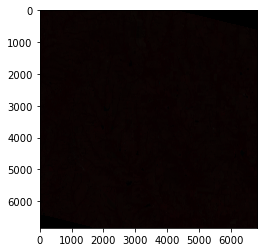

In [13]:
rgb = scale_img(image_c[..., [7, 5, 3]])
plt.imshow(rgb)

In [14]:
image = image_c[..., [7, 5, 3]]

image_view = image.copy()
for k in tqdm(range(3)):
    m0 = np.nanpercentile(image[~mask, k], 2)
    m1 = np.nanpercentile(image[~mask, k], 98)
    image_view[~mask, k] = np.clip(image[~mask, k], m0, m1)

100%|███████████████████████████████████████| 3/3 [00:07<00:00,  2.62s/it]


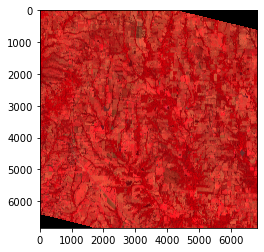

In [15]:
rgb = scale_img(image_view)
plt.imshow(rgb)

In [86]:
p_cropped = profile_cropped.copy()
p_cropped['count'] = 3
p_cropped['dtype'] = 'float32'
p_cropped['nodata'] = np.nan
with rasterio.open(f'cropped_to_chip_{index}.tif', 'w', **p_cropped) as ds:
    ds.write(rgb.transpose([2, 0, 1]))

You could use the above to figure out some training data. We label it `training_data_{index}`, according to the chip ID.

# Segmentation

Going to use multiscale superpixels - see [this paper](https://www.mdpi.com/2072-4292/12/12/2048) and the references. I learned about them [here](https://link.springer.com/chapter/10.1007/978-94-017-7239-6_8).

Best discussion of felzenswalb algorithm (and parameters below) is by a fellow JPL team: https://ieeexplore.ieee.org/document/5593215

In [17]:
def get_segmentation(image, min_size):
    mask = np.isnan(image[..., 0])
    image_seg = image.copy()
    # So that np.nans don't give us problems
    image_seg[mask, :] = -10_000
    segments_fz = felzenszwalb(image_seg,
                               # may want to play with this
                               scale=5, 
                               # normally gaussian filter is applied - can experiment
                               sigma=0.,
                               # minimum size of segments
                               min_size=min_size
                              )
    return segments_fz

We are going to use the RGB image from above.

In [18]:
get_segmentation_partial = lambda min_size: get_segmentation(rgb, min_size)
segmentations = list(map(get_segmentation_partial, tqdm([10, 25, 50])))

100%|██████████████████████████████████████| 3/3 [08:26<00:00, 168.71s/it]


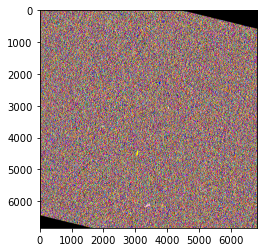

In [19]:
X = segmentations[0].copy()
X[mask] = 0
superpixel_labels_viz = label2rgb(X, bg_label=0)
plt.imshow(superpixel_labels_viz)

Below would be used to save the segments to a vector file. It takes some time and the segments can be approximately ~1 GB.

In [20]:
segments_fz = segmentations[1]

In [21]:
%%time

# features = get_geopandas_features_from_array(segments_fz.astype(np.int32), 
#                                              profile['transform'], 
#                                              label_name='label')

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.05 µs


In [22]:
%%time

# df_segments = gpd.GeoDataFrame.from_features(features)
# df_segments.head()

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 3.81 µs


In [23]:
%%time

# df_segments.crs = profile['crs']
# df_segments.to_file('segments.geojson', driver='GeoJSON')

CPU times: user 1e+03 ns, sys: 1e+03 ns, total: 2 µs
Wall time: 3.81 µs


# Generate Features

In [24]:
rgb.shape

(6838, 6840, 3)

In [25]:
pixel_features = rgb.reshape((-1, rgb.shape[-1]))

In [26]:
multi_superpixel_features_mean = [get_superpixel_means_as_features(seg, rgb) for seg in tqdm(segmentations)]

100%|███████████████████████████████████████| 3/3 [00:18<00:00,  6.19s/it]


In [27]:
multi_superpixel_features_mean[0].shape

(1371934, 3)

In [28]:
multi_superpixel_features_std = [get_superpixel_stds_as_features(seg, rgb) for seg in tqdm(segmentations)]

  0%|                                               | 0/3 [00:00<?, ?it/s]/Users/cmarshak/opt/anaconda3/envs/dswx_calval/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:523: RuntimeWarning: invalid value encountered in true_divide
  means = sums / counts
100%|███████████████████████████████████████| 3/3 [00:22<00:00,  7.55s/it]


In [29]:
multi_superpixel_means = [get_array_from_features(seg, feature) 
                          for (seg, feature) in zip(tqdm(segmentations),                                                                                                     multi_superpixel_features_mean)]
multi_superpixel_stds = [get_array_from_features(seg, feature) 
                          for (seg, feature) in zip(tqdm(segmentations),                                                                                                     multi_superpixel_features_std)]

100%|███████████████████████████████████████| 3/3 [00:27<00:00,  9.14s/it]


In [30]:
scale_ind = 0
img_super = multi_superpixel_means[scale_ind]
p['count'] = 3

with rasterio.open(f'superpixel_means_{scale_ind}_{index}.tif', 'w', **p) as ds:
    ds.write(img_super.transpose([2, 0, 1]))

In [31]:
scale_ind = 0
img_super = multi_superpixel_stds[scale_ind]
p['count'] = 3

with rasterio.open(f'superpixel_stds_{scale_ind}_{index}.tif', 'w', **p) as ds:
    ds.write(img_super.transpose([2, 0, 1]))

In [32]:
superpixel_means_pixel_f = [superpixel_means.reshape((-1, rgb.shape[-1])) 
                            for superpixel_means in multi_superpixel_means]
superpixel_stds_pixel_f = [superpixel_stds.reshape((-1, rgb.shape[-1])) 
                            for superpixel_stds in multi_superpixel_stds]

In [197]:
all_features = np.hstack(([pixel_features]  
                          + superpixel_means_pixel_f 
                          + superpixel_stds_pixel_f
                         ))
all_features.shape

(46771920, 21)

# Generate Training Data

Using Peckel Occurance data to generate training data

In [56]:
from osgeo import gdal
from dem_stitcher.rio_window import read_raster_from_window
from rasterio.warp import transform_bounds

def build_peckel_vrt(extent: list, 
                     out_path: Path):
    df_peckel_data = gpd.read_file('peckel_tiles.geojson')
    bbox = box(*extent)
    ind_inter = df_peckel_data.geometry.intersects(bbox)
    df_subset = df_peckel_data[ind_inter].reset_index(drop=True)
    gdal.BuildVRT(str(out_path), df_subset.source_url.tolist())
    return out_path

def get_peckel_raster(extent:list) -> tuple:
    tmp_vrt = Path('peckel_data_tmp.vrt')
    build_peckel_vrt(extent, tmp_vrt)
    X, p = read_raster_from_window(tmp_vrt,
                                   extent,
                                   CRS.from_epsg(4326))
    tmp_vrt.unlink()
    p['driver'] = 'GTiff'
    return X, p

In [59]:
df_chip.to_crs(4326).total_bounds

array([-95.97375,  32.94   , -95.76   ,  33.12   ])

In [60]:
X_occ, p_occ = get_peckel_raster(df_chip.to_crs(4326).total_bounds)

In [372]:
with rasterio.open(f'occurence_c{index}.tif', 'w', **p_occ) as ds:
    ds.write(X_occ, 1)

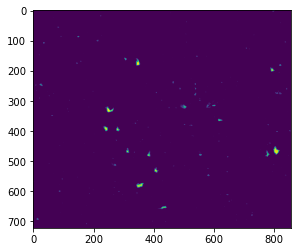

In [61]:
plt.imshow(X_occ)

In [319]:
from scipy import ndimage

OCC_MIN = 35
DIST_TO_EXTENT = 5

water_ind = (X_occ >= OCC_MIN)
water_extent = (X_occ > 0)

water_extent_arr = (~water_extent).astype(int)
water_dist = ndimage.distance_transform_edt(water_extent_arr)

land_ind = water_dist > DIST_TO_EXTENT

Text(0.5, 1.0, 'Land Mask')

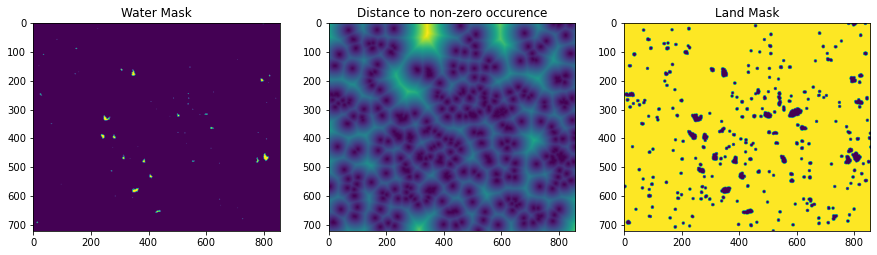

In [320]:
fig, ax = plt.subplots(1, 3, figsize=(15,5))

ax[0].imshow(water_ind)
ax[0].set_title('Water Mask')

ax[1].imshow(water_dist)
ax[1].set_title('Distance to non-zero occurence')

ax[2].imshow(land_ind)
ax[2].set_title('Land Mask')

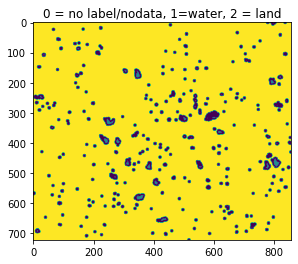

In [321]:
training_data_4326 = np.zeros(X_occ.shape)
training_data_4326[land_ind] = 2
training_data_4326[water_ind] = 1
plt.title('0 = no label/nodata, 1=water, 2 = land')
plt.imshow(training_data_4326)

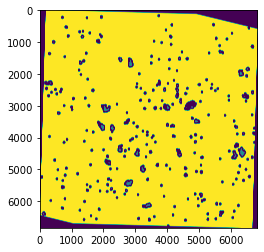

In [339]:
p_temp = p_occ.copy()
p_temp['dtype'] = 'float32'
p_temp['nodata'] = None

training_data_r, p_r = reproject_arr_to_match_profile(training_data_4326, p_temp, p_cropped)
# rounding then casting makes sure the class assigned is closest after reprojection
training_data_r = training_data_r[0, ...]
training_data_r[mask] = 0

plt.imshow(training_data_r)

In [340]:
with rasterio.open('test_train.tif', 'w', **p_r) as ds:
    ds.write(training_data_r, 1)

In [341]:
labels = training_data_r.copy()

In [342]:
labels_f = labels.reshape((-1, 1)).ravel()

f_mask = ~(labels_f == 0).ravel()

In [343]:
X_labeled_all = all_features[f_mask]
y_labeled_all = labels_f[f_mask]

There must be a better way to do this - this makes sure training data has equal water and land, the later which is much more over-represented. Think something like this will do: https://imbalanced-learn.org/stable/auto_examples/applications/plot_multi_class_under_sampling.html#sphx-glr-auto-examples-applications-plot-multi-class-under-sampling-py

In [358]:
np.random.seed(0)
water_ind_f = np.where(y_labeled_all == 1)[0]
land_ind_f = np.where(y_labeled_all == 2)[0]
n = water_ind_f.shape[0]
land_ind_f_sample = np.random.choice(land_ind_f, size=n)

indices_for_labeling = np.hstack([water_ind_f, land_ind_f_sample])
indices_for_labeling.shape

y_labeled = y_labeled_all[indices_for_labeling].astype(int)
X_labeled = X_labeled_all[indices_for_labeling, ...]

In [359]:
X_train, X_test, y_train, y_test = train_test_split(X_labeled, 
                                                    y_labeled, 
                                                    test_size=0.2,
                                                    train_size=0.8,
                                                    random_state=0,
                                                    stratify=y_labeled
                                                   )

In [360]:
rf = RandomForestClassifier(n_estimators=500,
                            oob_score=True,
                            random_state=0,
                            n_jobs=8)

In [361]:
%%time

rf.fit(X_train, 
       y_train)

CPU times: user 3min 26s, sys: 1.48 s, total: 3min 27s
Wall time: 30.9 s


RandomForestClassifier(n_estimators=500, n_jobs=8, oob_score=True,
                       random_state=0)

In [362]:
%%time

y_pred = rf.predict(X_test)

CPU times: user 1.86 s, sys: 47.6 ms, total: 1.91 s
Wall time: 253 ms


In [363]:
class_dict = {1: 'water', 
              2: 'not_water'}

In [364]:
y_pred_str = pd.Series([class_dict[class_id] for class_id in y_pred], name='Predicted')
y_true_str = pd.Series([class_dict[class_id] for class_id in y_test], name='True')

This gives us how well we did on the labeled test data. Random forests will do pretty well on the labeled data since the labeled data is continugous and the superpixels aggregations will likely be shared across pixels.

In [365]:
df = pd.crosstab(y_true_str, y_pred_str)
df

Predicted,not_water,water
True,,
not_water,16204,6
water,3,16207


In [366]:
all_mask_f = (mask.reshape((-1,)))

X_all = all_features[~all_mask_f, 
                     ...]

In [367]:
%%time

y_all = rf.predict(X_all)

CPU times: user 27min 26s, sys: 4min, total: 31min 26s
Wall time: 4min 26s


In [368]:
y_arr = np.zeros(mask.shape)

y_arr[~mask] = y_all
y_arr[mask] = 0

In [369]:
p = profile_cropped.copy()
p['count'] = 1 
p['dtype'] = np.uint8
with rasterio.open(f'class_out_{index}.tif', 'w', **p) as ds:
    ds.write(y_arr.astype(np.uint8), 1)

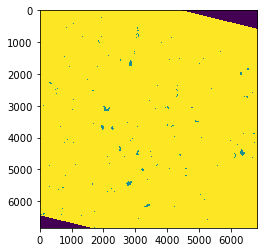

In [370]:
plt.imshow(y_arr, interpolation='none')

# Feature Importances

See: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.feature_importances_

In [371]:
rf.feature_importances_

array([0.15558539, 0.00290431, 0.00248995, 0.1166433 , 0.00548212,
       0.00551477, 0.20229511, 0.00601769, 0.0052912 , 0.2128438 ,
       0.00635225, 0.00580219, 0.09534632, 0.01174741, 0.00581022,
       0.0603687 , 0.02208378, 0.01010069, 0.04718485, 0.01308572,
       0.00705022])